# XGBoost models to predict electricity demand in December 2022

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import xgboost as xgb

import seaborn as sns

# Creating dataset with relevant features

### ENTSO-E electricity demand data

In [2]:
yr_2016 = pd.read_csv("Total Load - Day Ahead _ Actual_201601010000-201701010000.csv")
yr_2017 = pd.read_csv("Total Load - Day Ahead _ Actual_201701010000-201801010000.csv")
yr_2018 = pd.read_csv("Total Load - Day Ahead _ Actual_201801010000-201901010000.csv")
yr_2019 = pd.read_csv("Total Load - Day Ahead _ Actual_201901010000-202001010000.csv")
yr_2020 = pd.read_csv("Total Load - Day Ahead _ Actual_202001010000-202101010000.csv")
yr_2021 = pd.read_csv("Total Load - Day Ahead _ Actual_202101010000-202201010000.csv")
yr_2022 = pd.read_csv("Total Load - Day Ahead _ Actual_202201010000-202301010000.csv")

demand_dataframes=(yr_2016, yr_2017, yr_2018, yr_2019, yr_2020, yr_2021, yr_2022)

demand_2016_2022=pd.DataFrame()
#Converts dataframes to datetime files and adding them to get one single dataframe.
for dataframe in demand_dataframes:
    dataframe.index=pd.to_datetime(dataframe.iloc[:,0].str.split(" - ").str[0], dayfirst=True)
    demand_2016_2022 = pd.concat([demand_2016_2022, dataframe], ignore_index=False)
    
#deleting unnecessary columns
demand_2016_2022=demand_2016_2022.drop(["Day-ahead Total Load Forecast [MW] - BZN|NO1"], axis=1)
demand_2016_2022=demand_2016_2022.drop(["Time (CET/CEST)"], axis=1)

#24 NaN values, so I replace them using forward fill.
demand_2016_2022["Actual Total Load [MW] - BZN|NO1"].isna().sum()
demand_2016_2022["Actual Total Load [MW] - BZN|NO1"].fillna(method='ffill', inplace=True)
demand_2016_2022

#there are seven too many rows in the dataframe, so I check for duplicates.
duplicate_indices = demand_2016_2022.index.duplicated(keep=False)
#print(demand_2016_2022[duplicate_indices])

#deleting duplicates
demand_2016_2022 = demand_2016_2022[~demand_2016_2022.index.duplicated(keep='last')]

## Temperature and precipitation data
Norsk KlimaServiceSenter (https://seklima.met.no/)

In [5]:
weather=pd.read_csv("Temperature and rain 2016-2022.csv", sep=';')

#deleting the two last columns
weather=weather[:-2]

weather["Lufttemperatur"] = weather["Lufttemperatur"].str.replace(',', '.').astype(float)
weather["Nedbør (1 t)"] = pd.to_numeric(weather["Nedbør (1 t)"].str.replace(',', '.'), errors='coerce')


#checking for NaN values
weather["Lufttemperatur"].isna().sum() #0 values
weather["Nedbør (1 t)"].isna().sum() #1 value
weather["Nedbør (1 t)"] = weather["Nedbør (1 t)"].interpolate()

#Changes dataframe index to datetime
weather.index=pd.to_datetime(weather.iloc[:,2], dayfirst=True)
weather = weather.rename_axis("Time (CET/CEST)")
weather=weather.drop(["Navn","Stasjon", "Tid(norsk normaltid)"], axis=1)

## Creates one common dataframe with both electricity demand and weather data 

In [6]:
inf_dataframe=pd.read_csv("inflasjon2015_2022.csv")
inf_dataframe.index=inf_dataframe["time"]
inf_dataframe = inf_dataframe.rename_axis("Time (CET/CEST)")
inf_dataframe = inf_dataframe.drop(["time"], axis=1)
inf_dataframe.index=pd.to_datetime(inf_dataframe.index)

In [7]:
feature_dataframe = pd.merge(weather, demand_2016_2022, on="Time (CET/CEST)")
feature_dataframe.to_csv('feature_dataframe.tsv', sep='\t', index=False)

In [8]:
feature_dataframe['hour'] = feature_dataframe.index.hour
feature_dataframe['day_of_week'] = feature_dataframe.index.dayofweek + 1 #such that monday is 1 rather than 0
feature_dataframe['month'] = feature_dataframe.index.month
feature_dataframe['year'] = feature_dataframe.index.year
feature_dataframe

,Lufttemperatur,Nedbør (1 t),Actual Total Load [MW] - BZN|NO1,hour,day_of_week,month,year
Time (CET/CEST),,,,,,,
2016-01-01 00:00:00,1.1,0.1,4582.0,0,5,1,2016
2016-01-01 01:00:00,1.1,0.3,4482.0,1,5,1,2016
2016-01-01 02:00:00,1.1,0.6,4421.0,2,5,1,2016
2016-01-01 03:00:00,0.9,0.9,4335.0,3,5,1,2016
2016-01-01 04:00:00,1.2,0.4,4304.0,4,5,1,2016
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.9,0.0,4824.0,19,6,12,2022
2022-12-31 20:00:00,0.2,0.0,4650.0,20,6,12,2022
2022-12-31 21:00:00,-1.0,0.0,4573.0,21,6,12,2022


#### Splitting feature variables from target

In [9]:
X = feature_dataframe.drop('Actual Total Load [MW] - BZN|NO1', axis=1)
y = feature_dataframe['Actual Total Load [MW] - BZN|NO1']

In [10]:
#fig, ax = plt.subplots(figsize=(10, 8))
#sns.boxplot(data=feature_dataframe, x='month', y='Actual Total Load [MW] - BZN|NO1')
#ax.set_title('average MW by Hour')
#plt.show()

In [11]:
#Empty dataframe
df = pd.DataFrame()

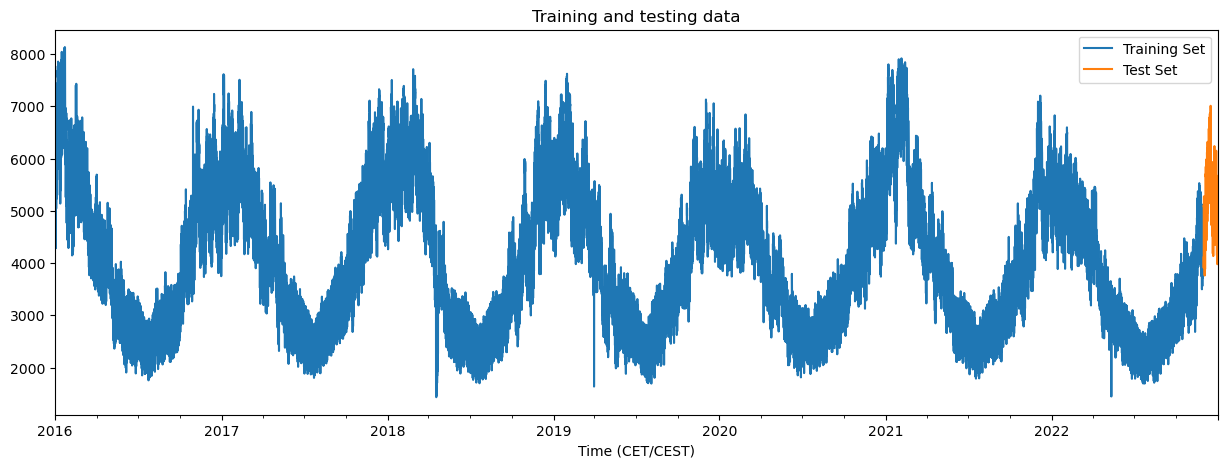

In [12]:
#creates a dataframe that contains all the features. Useful when trying different amounts of data
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['temperature'] = df["Lufttemperatur"]
    df['precipitation'] = df["Nedbør (1 t)"]
    return df
df = create_features(feature_dataframe)

#defines cutoff date for training and testing set
train = feature_dataframe.loc[df.index < '12-01-2022']
test = feature_dataframe.loc[df.index >= '12-01-2022']

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day_of_week', 'month', 'year', 'Lufttemperatur', 'Nedbør (1 t)']
TARGET = 'Actual Total Load [MW] - BZN|NO1'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

fig, ax = plt.subplots(figsize=(15, 5))
train["Actual Total Load [MW] - BZN|NO1"].plot(label='Training Set')
test["Actual Total Load [MW] - BZN|NO1"].plot(label='Test Set')
ax.set_title("Training and testing data")
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Tries XGBoost on the whole dataset before tuning parameters

In [20]:
reg = xgb.XGBRegressor(base_score=y_train.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse', 
        verbose=0)

# Make predictions
y_pred = reg.predict(X_test)

# Calculate R2 manually
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


R2 Score: 0.8687806714721551


---------

# Parameter tuning
### Parameters to tune are:
- Learning rate
- Regularization parameter L2 (RIDGE)
- Regularization parameter L1 (LASSO)
- Maximum tree depth
- Gamma (minimum loss reduction required to split a branch. functions a bit like a regulatization parameter to prevent overfitting)
- N_estimators (Number of gradient boosted trees)

##### other possible parameters to tune:
- min_child_weight

---------

## Seaborn heatplots for tuning hyperparameters - not used in report

### Max depth vs. learning rate

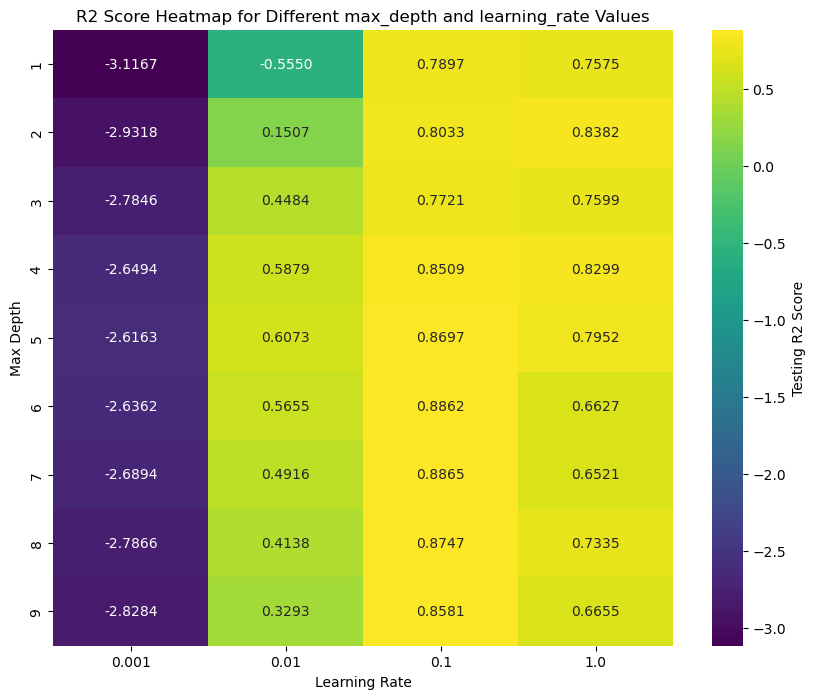

In [17]:
np.random.seed(123)

max_depth_values = range(1, 10)
learning_rate_values = np.array([0.001, 0.01, 0.1, 1])

results_df = pd.DataFrame(index=max_depth_values, columns=learning_rate_values)
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        reg = xgb.XGBRegressor(
            base_score=y_train.mean(),
            booster='gbtree',
            reg_lambda=0,
            n_estimators=100,
            early_stopping_rounds=500,
            objective='reg:squarederror', 
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=123 
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        y_pred = reg.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        results_df.at[max_depth, learning_rate] = r2

results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing R2 Score'})
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('R2 Score Heatmap for Different max_depth and learning_rate Values')
plt.show()

### Regularization parameter (Lambda) vs. learning rate

nb! alpha (LASSO) regression also possible

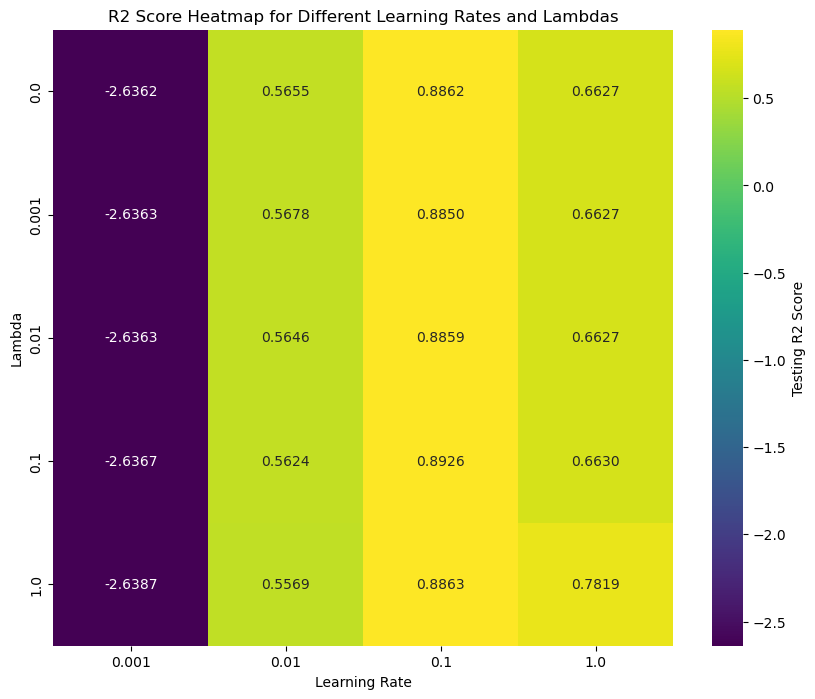

In [18]:
np.random.seed(123)

learning_rate_values = np.array([0.001, 0.01, 0.1, 1])
lambda_values = np.array([0, 0.001, 0.01, 0.1, 1])

results_df = pd.DataFrame(index=learning_rate_values, columns=lambda_values)

for learning_rate in learning_rate_values:
    for lambda_val in lambda_values:
        reg = xgb.XGBRegressor(
            base_score=y_train.mean(),
            booster='gbtree',
            max_depth=6, 
            n_estimators=100,
            early_stopping_rounds=500,
            objective='reg:squarederror',
            learning_rate=learning_rate,
            reg_lambda=lambda_val,
            random_state=123
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        results_df.at[learning_rate, lambda_val] = r2

results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df.T, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing R2 Score'})
plt.xlabel('Learning Rate')
plt.ylabel('Lambda')
plt.title('R2 Score Heatmap for Different Learning Rates and Lambdas')
plt.show()


### Lambda vs. gamma
might be redundant to use both of them?? given that both aim to reduce overfitting

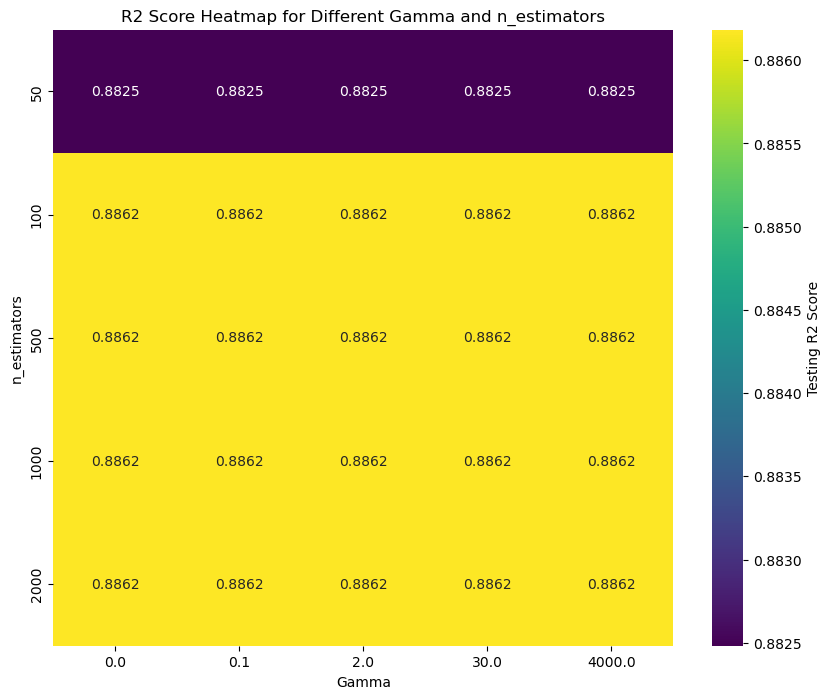

In [22]:
np.random.seed(123)
gamma_values = np.array([0, 0.1, 2, 30, 4000])
trees_values = np.array([50, 100, 500, 1000, 2000])

results_df = pd.DataFrame(index=gamma_values, columns=trees_values)
for gamma_val in gamma_values:
    for trees_value in trees_values:
        reg = xgb.XGBRegressor(
            base_score=y_train.mean(),
            booster='gbtree',
            max_depth=6,
            n_estimators=trees_value,
            early_stopping_rounds=500,
            objective='reg:squarederror',
            gamma=gamma_val,
            learning_rate=0.1,
            reg_lambda=0.0,
            random_state=123
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        y_pred = reg.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        results_df.at[gamma_val, trees_value] = r2
results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df.T, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing R2 Score'})
plt.xlabel('Gamma')
plt.ylabel('n_estimators')
plt.title('R2 Score Heatmap for Different Gamma and n_estimators')
plt.show()

### Check for autocorrelation?
Autocorrelation every 7 days? Maybe 7 days is enough as a lookback period?

### Check for different amounts of data
#### six years, two years, one year, one month, one week

In [23]:
X_train_tot = X_train ; y_train_tot = y_train #total dataset from 2016-2022 minus last month as test set.
X_train_year = X_train.loc[X_train.index >= '12-01-2021'] ; y_train_year = y_train.loc[y_train.index >= '12-01-2021'] #only the year of 2022
X_train_month = X_train.loc[X_train.index >= '11-01-2022'] ; y_train_month = y_train.loc[y_train.index >= '11-01-2022'] #only November 2022
X_train_twoyears = X_train.loc[X_train.index >= '01-01-2021'] ; y_train_twoyears = y_train.loc[y_train.index >= '01-01-2021'] #only the year of 2022
X_train_week = X_train.loc[X_train.index >= '11-24-2022'] ; y_train_week = y_train.loc[y_train.index >= '11-24-2022'] #only November 2022
X_train_fouryears = X_train.loc[X_train.index >= '01-01-2019'] ; y_train_fouryears = y_train.loc[y_train.index >= '01-01-2019'] #only the year of 2022

# Finds R2 scores for models made with six different training datasets: Six years, four years, two years, one year, one month and one week. Not all of them are used in report

## Six years of training data

In [43]:
reg_tot = xgb.XGBRegressor(base_score=y_train_tot.mean(),
                           booster='gbtree',
                           n_estimators=100,
                           early_stopping_rounds=500,
                           objective='reg:squarederror',
                           max_depth=6,
                           learning_rate=0.1,
                           reg_alpha=0.0,
                           reg_lambda=0.1,
                           gamma=0,
                           random_state=123)

results = reg_tot.fit(X_train_tot, y_train_tot,
                      eval_set=[(X_train_tot, y_train_tot), (X_test, y_test)],
                      eval_metric="rmse",
                      verbose=0)

y_pred_tot = reg_tot.predict(X_test)

training_r2_tot = r2_score(y_train_tot, reg_tot.predict(X_train_tot))
testing_r2_tot = r2_score(y_test, y_pred_tot)
print("Training R2-score: ",training_r2_tot)
print("Testing R2-score: "testing_r2_tot)


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


0.8925571084690809
0.9744007389223431


## One year of training data

In [47]:
reg_year = xgb.XGBRegressor(base_score=y_train_year.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=2,
                       learning_rate=0.1,
                       reg_alpha=0.1,
                       reg_lambda=0.1,
                       gamma=0,
                       random_state=123)


results = reg_year.fit(X_train_year, y_train_year,
                       eval_set=[(X_train_year, y_train_year), (X_test, y_test)],
                       eval_metric="rmse",  
                       verbose=0)

y_pred_year = reg_year.predict(X_test)

training_r2_year = r2_score(y_train_year, reg_year.predict(X_train_year))
testing_r2_year = r2_score(y_test, y_pred_year)

print("Training R2-score: ",training_r2_year)
print("Testing R2-score: ",testing_r2_year)

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Testing R2:  0.7762437478889318
Training R2:  0.9714723398974863


## One month of training data

In [52]:
# Define the parameter found in the grid search
reg_month = xgb.XGBRegressor(base_score=y_train_month.mean(), booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=2,
                       learning_rate=0.2,
                       reg_alpha=0.1,
                       reg_lambda=0.001,
                       gamma=0,
                       random_state=123)


results = reg_month.fit(X_train_month, y_train_month,
                       eval_set=[(X_train_month, y_train_month), (X_test, y_test)],
                       eval_metric="rmse", 
                       verbose=0)

y_pred_month = reg_month.predict(X_test)

training_r2_month = r2_score(y_train_month, reg_month.predict(X_train_month))
testing_r2_month = r2_score(y_test, y_pred_month)

print("Training R2-score: ",training_r2_month)
print("Testing R2-score: ",testing_r2_month)

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training R2 Score: 0.9793436147252838
Testing R2 Score: 0.048711434848762836


## 1 Week of training data

In [54]:
reg_week = xgb.XGBRegressor(base_score=y_train_week.mean(), booster='gbtree',    
                            n_estimators=1000,
                            early_stopping_rounds=500,
                            objective='reg:squarederror', 
                            max_depth=2,
                            learning_rate=0.1,
                            reg_alpha=0.001,
                            reg_lambda=0.001,
                            gamma=0,
                            random_state=123)

results_week = reg_week.fit(X_train_week, y_train_week,
                            eval_set=[(X_train_week, y_train_week), (X_test, y_test)],
                            eval_metric="rmse", 
                            verbose=0)

y_pred_week = reg_week.predict(X_test)

training_r2_week = r2_score(y_train_week, reg_week.predict(X_train_week))
testing_r2_week = r2_score(y_test, y_pred_week)

print("Training R2-score: ",training_r2_week)
print("Testing R2-score: ",testing_r2_week)

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training R2-score:  0.992947924674664
Testing R2-score:  -0.6351492823920268


performs worse than using the average value of the week prior to December

## Two years of training data

In [55]:
reg_twoyears = xgb.XGBRegressor(base_score=y_train_twoyears.mean(), booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=500,
                       objective='reg:squarederror', 
                       max_depth=3,
                       learning_rate=0.2,
                       reg_alpha=0.1,
                       reg_lambda=0.01,
                       gamma=0,
                       random_state=123)


results = reg_twoyears.fit(X_train_twoyears, y_train_twoyears,
                       eval_set=[(X_train_twoyears, y_train_twoyears), (X_test, y_test)],
                       eval_metric="rmse", 
                       verbose=0)

y_pred_twoyears = reg_twoyears.predict(X_test)

training_r2_twoyears = r2_score(y_train_twoyears, reg_twoyears.predict(X_train_twoyears))
testing_r2_twoyears = r2_score(y_test, y_pred_twoyears)

print("Training R2-score: ",training_r2_twoyears)
print("Testing R2-score: ",testing_r2_twoyears)

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training R2-score:  0.9764492501323682
Testing R2-score:  0.8330205004842386


## Four years of training data

In [59]:
# Define the parameter found in the grid search
reg_fouryears = xgb.XGBRegressor(base_score=y_train_fouryears.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  # Update this line
                       max_depth=3,
                       learning_rate=0.1,
                       reg_alpha=0.0,
                       reg_lambda=0.1,
                       gamma=0,
                       random_state=123)


results = reg_fouryears.fit(X_train_fouryears, y_train_fouryears,
                       eval_set=[(X_train_fouryears, y_train_fouryears), (X_test, y_test)],
                       eval_metric="rmse",  # Use RMSE as the evaluation metric
                       verbose=0)

y_pred_fouryears = reg_fouryears.predict(X_test)

training_r2_fouryears = r2_score(y_train_fouryears, reg_fouryears.predict(X_train_fouryears))
testing_r2_fouryears = r2_score(y_test, y_pred_fouryears)

print("Training R2-score: ",training_r2_fouryears)
print("Testing R2-score: ",testing_r2_fouryears)

C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training R2-score:  0.9786182319956214
Testing R2-score:  0.8208147914734562


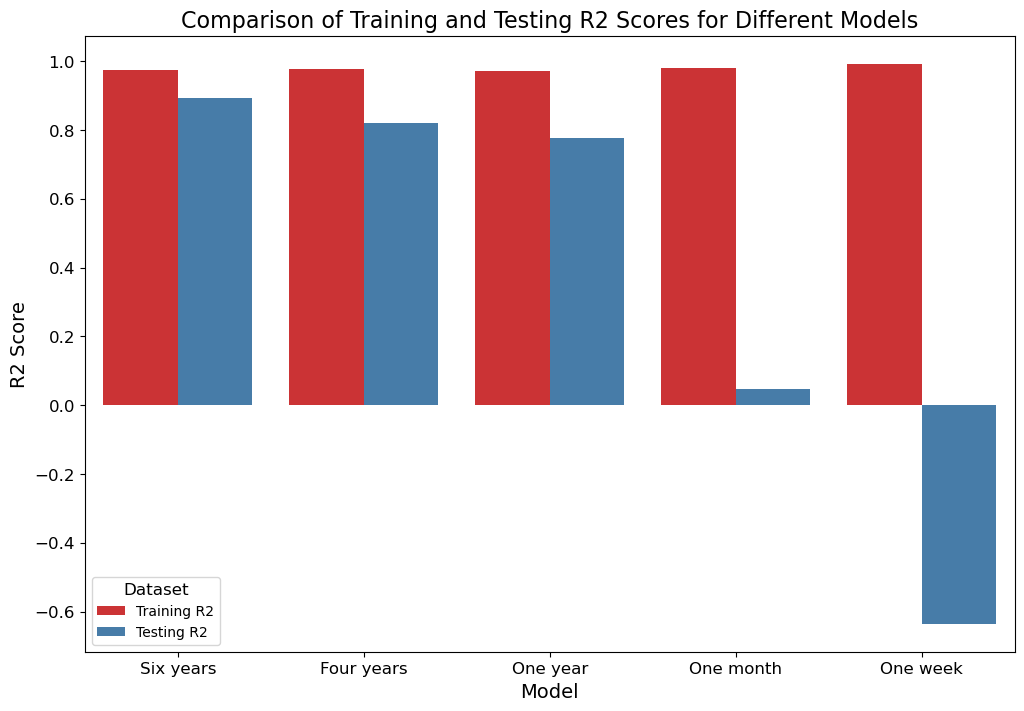

In [67]:
models = ['Six years', 'Four years', 'One year', 'One month', 'One week']
training_r2 = [training_r2_tot, training_r2_fouryears, training_r2_year, training_r2_month, training_r2_week]
testing_r2 = [testing_r2_tot, testing_r2_fouryears, testing_r2_year, testing_r2_month, testing_r2_week]

r2_df = pd.DataFrame({'model': models, 'Training R2': training_r2, 'Testing R2': testing_r2})
r2_df_plot = pd.melt(r2_df, id_vars=['model'], value_vars=['Training R2', 'Testing R2'], var_name='Dataset', value_name='R2 Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='model', y='R2 Score', hue='Dataset', data=r2_df_plot, palette=sns.color_palette("Set1"))
plt.title('Comparison of Training and Testing R2 Scores for Different Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R2 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Dataset', title_fontsize='12', fontsize='10')
plt.savefig("r2_score.png")
plt.show()